<a href="https://colab.research.google.com/github/mariemouertani104/Simulation-Avanc-e-Wi-Fi-6-7-OFDMA-MU-MIMO-et-Multi-Link-Operation-avec-Python/blob/main/Simulation_Avanc%C3%A9e_Wi%E2%80%91Fi_6_%26_7_OFDMA%2C_MU%E2%80%91MIMO_et_Multi%E2%80%91Link_Operation_avec_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Un notebook Python Colab “pro” simulant un scénario Wi‑Fi 6 / Wi‑Fi 7 avancé, avec :

*OFDMA (allocation de Resource Units)

*MU‑MIMO simplifié (beamforming toy model)

*Multi‑Link Operation (MLO, Wi‑Fi 7)

*Visualisation professionnelle avec matplotlib et seaborn

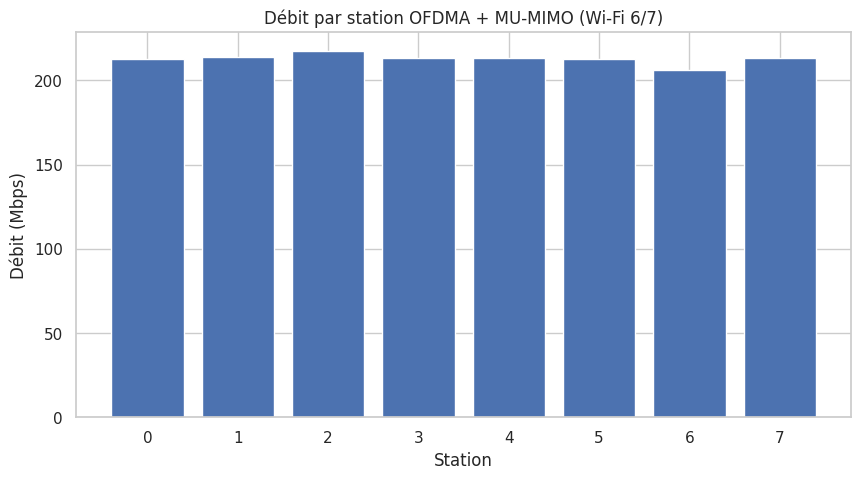

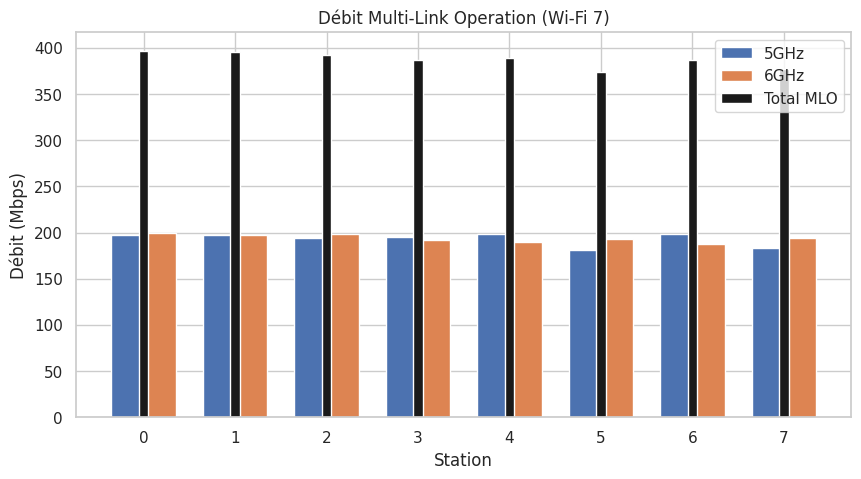

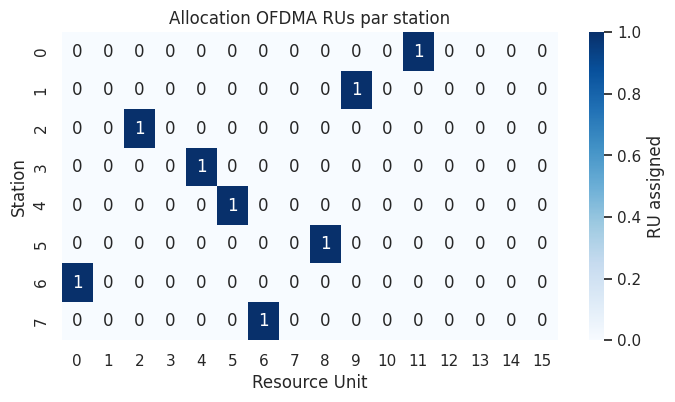

In [2]:
# WiFi 6/7 Advanced Simulation
# OFDMA + MU-MIMO + Multi-Link Operation
# Auteur: Meriem Simulation Example

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ====== Paramètres généraux ======
BW_total = 160e6         # bande passante totale 160 MHz (Wi-Fi 7)
num_RU = 16              # nombre de Resource Units
RU_bw = BW_total / num_RU

N_sta = 8                # nombre de stations
N_ant = 4                # nombre d'antennes à l'AP (MU-MIMO)
tx_power = 1e-3          # puissance émise par AP (W)
noise = 1e-9             # puissance du bruit
np.random.seed(42)

# ====== Simuler gains de canal multi-RU pour chaque STA ======
# gains entre 0 et 1
chan_gains = np.random.rand(N_sta, num_RU)

# ====== OFDMA: Allocation des RUs ======
alloc = np.zeros((N_sta, num_RU), dtype=int)
for sta in range(N_sta):
    sorted_idx = np.argsort(-chan_gains[sta])  # trier RUs par meilleur gain
    for idx in sorted_idx:
        if alloc[:, idx].sum() == 0:  # si RU libre
            alloc[sta, idx] = 1
            break

# ====== MU-MIMO: Simuler beamforming (toy model) ======
# vecteurs de beamforming aléatoires et normalisés
beamforming_vectors = np.random.rand(N_ant, N_sta) + 1j*np.random.rand(N_ant, N_sta)
beamforming_vectors /= np.linalg.norm(beamforming_vectors, axis=0)

# Débit par station (Shannon simplifié)
rates = []
for sta in range(N_sta):
    ru_idx = np.where(alloc[sta]==1)[0]
    if len(ru_idx) > 0:
        gain = chan_gains[sta, ru_idx[0]]
        # MU-MIMO effet: factorisation simplifiée
        bf_gain = np.abs(np.sum(beamforming_vectors[:, sta]))**2
        snr = (tx_power * gain * bf_gain)/noise
        rate = RU_bw * np.log2(1 + snr)  # bits/s
    else:
        rate = 0
    rates.append(rate/1e6)  # en Mbps

# ====== Multi-Link Operation (MLO) ======
# Supposons deux bandes: 5GHz et 6GHz
BW_links = [80e6, 80e6]
num_RU_links = [8, 8]
rates_links = []

for link in range(2):
    BW = BW_links[link]
    RUs = num_RU_links[link]
    RU_bw_link = BW / RUs
    # gains aléatoires pour cette bande
    gains_link = np.random.rand(N_sta, RUs)
    # allocation simple
    alloc_link = np.zeros((N_sta, RUs), dtype=int)
    for sta in range(N_sta):
        sorted_idx = np.argsort(-gains_link[sta])
        for idx in sorted_idx:
            if alloc_link[:, idx].sum() == 0:
                alloc_link[sta, idx] = 1
                break
    # calcul débit par station pour ce lien
    rates_link = []
    for sta in range(N_sta):
        ru_idx = np.where(alloc_link[sta]==1)[0]
        if len(ru_idx) > 0:
            gain = gains_link[sta, ru_idx[0]]
            snr = (tx_power * gain)/noise
            rate = RU_bw_link * np.log2(1 + snr)
        else:
            rate = 0
        rates_link.append(rate/1e6)
    rates_links.append(rates_link)

# somme des deux liens = débit multi-link
rates_MLO = np.array(rates_links[0]) + np.array(rates_links[1])

# ====== Visualisations ======

# 1. Débit OFDMA + MU-MIMO
plt.figure(figsize=(10,5))
plt.bar(range(N_sta), rates)
plt.xlabel("Station")
plt.ylabel("Débit (Mbps)")
plt.title("Débit par station OFDMA + MU-MIMO (Wi-Fi 6/7)")
plt.show()

# 2. Débit Multi-Link
plt.figure(figsize=(10,5))
width = 0.35
x = np.arange(N_sta)
plt.bar(x - width/2, rates_links[0], width, label="5GHz")
plt.bar(x + width/2, rates_links[1], width, label="6GHz")
plt.bar(x, rates_MLO, width=0.1, label="Total MLO", color='k')
plt.xlabel("Station")
plt.ylabel("Débit (Mbps)")
plt.title("Débit Multi-Link Operation (Wi-Fi 7)")
plt.legend()
plt.show()

# 3. Heatmap allocation OFDMA
plt.figure(figsize=(8,4))
sns.heatmap(alloc, annot=True, cmap="Blues", cbar_kws={'label': 'RU assigned'})
plt.xlabel("Resource Unit")
plt.ylabel("Station")
plt.title("Allocation OFDMA RUs par station")
plt.show()
